# 进一步寻找最佳模型
- 去掉相关性比较低的特征

In [1]:
import pandas as pd
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv("./data/train_1.csv")

In [3]:
train.columns

Index(['Unnamed: 0', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond

In [4]:
if 'Unnamed: 0' in train.columns:
    train=train.drop(['Unnamed: 0'],axis=1)

In [5]:
def test_data_set(train):
    y=train['SalePrice']
    train2=train.drop(['Id','SalePrice'],axis=1)
    X=pd.get_dummies(train2)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
    xg_reg=xgb.XGBRegressor(objective='reg:linear',
                            colsample_bytree=0.7,
                            learning_rate=0.01,
                            max_depth=3,
                            n_estimators=3000,
                            subsample=0.7,
                            reg_alpha=0.0006,
                            nthread=6)
    xg_reg.fit(X_train,y_train)
    benchmark1(xg_reg,X_test,y_test)

In [6]:
def benchmark1(model, testset, label):
    pred=model.predict(testset)
    if pred[pred<0].shape[0]>0:
        print('Neg Value')
    rmse=np.sqrt(mean_squared_error(label, pred))
    lrmse=np.sqrt(mean_squared_error(np.log(label),np.log(pred)))
    print('RMSE:', rmse)
    print('LRMSE:', lrmse)
    return lrmse

In [7]:
test_data_set(train)

RMSE: 23427.86572579868
LRMSE: 0.1033732240884543


# 1 去掉相关性比较低的特征再训练模型

In [8]:
c = train.corr()['SalePrice']

In [9]:
c

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.339782
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.261366
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
SqrtLotArea 

## 1.1 去掉极弱相关的特征|corr|<0.3

In [10]:
def test_data_set1(train):
    y=train['SalePrice']
    train2=train.drop(['SalePrice'],axis=1)
    X=pd.get_dummies(train2)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
    xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3000,subsample=0.7,reg_alpha=0.0006,nthread=6)
    xg_reg.fit(X_train,y_train)
    benchmark1(xg_reg,X_test,y_test)

In [11]:
test_data_set1(train.drop(c[abs(c)<0.3].index.tolist(),axis=1))

RMSE: 24493.170974380915
LRMSE: 0.1092756690472248


## 1.2 去掉相关性绝对值小于0.1的特征列

In [12]:
test_data_set1(train.drop(c[abs(c)<0.1].index.tolist(),axis=1))

RMSE: 23953.771426822474
LRMSE: 0.10829674662542016


## 1.3 去掉相关性小于0.1的特征列

In [13]:
test_data_set1(train.drop(c[c<0.1].index.tolist(),axis=1))

RMSE: 23408.818211833623
LRMSE: 0.10631323797733613


## 1.4 去掉正相关，且相关性小于0.1的特征列

In [14]:
test_data_set1(train.drop(c[(c > 0.0) & (c < 0.1)].index.tolist(),axis=1))

RMSE: 22649.285619533886
LRMSE: 0.10140269159104583


## 2 Target的偏度分析

In [15]:
import seaborn as sns

/Users/lyy/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


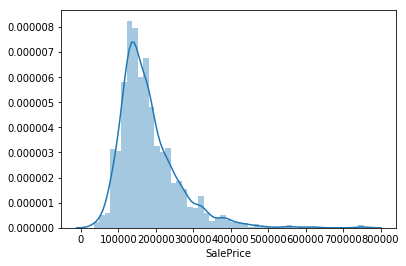

In [16]:
# 房价查看分布
sns.distplot(train['SalePrice'])

## 2.1 使用降次函数调整数据的偏度

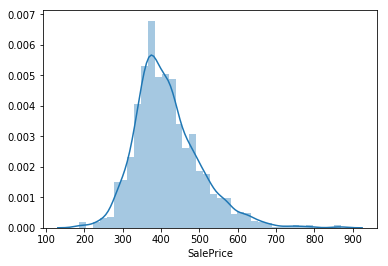

In [17]:
sns.distplot(np.sqrt(train['SalePrice']))

## 2.2 使用log函数调整数据的偏度

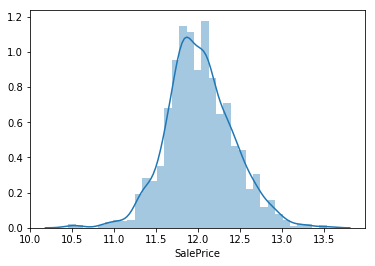

In [18]:
sns.distplot(np.log(train['SalePrice']))

In [19]:
def test_data_set2(train):
    y=np.log(train['SalePrice'])
    train2=train.drop(['Id','SalePrice'],axis=1)
    X=pd.get_dummies(train2)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
    xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3000,subsample=0.7,reg_alpha=0.0006,nthread=6)
    xg_reg.fit(X_train,y_train)
    pred=xg_reg.predict(X_test)
    print(np.sqrt(mean_squared_error(pred,y_test)))

In [20]:
test_data_set2(train)

0.10580851594195832


In [21]:
def test_data_set3(train):
    y=np.sqrt(train['SalePrice'])
    if 'Id' in train.columns:
        train2=train.drop(['Id','SalePrice'],axis=1)
    else:
        train2=train.drop(['SalePrice'],axis=1)
    X=pd.get_dummies(train2)
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=123)
    xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3000,subsample=0.7,reg_alpha=0.0006,nthread=6)
    xg_reg.fit(X_train,y_train)
    #benchmark1(xg_reg,X_test,y_test)
    pred=xg_reg.predict(X_test)
    pred=pred**2
    y_test=y_test**2
    print(np.sqrt(mean_squared_error(np.log(pred),np.log(y_test))))

In [22]:
test_data_set3(train)

0.10545847727826224


In [23]:
test_data_set3(train.drop(c[(c > 0.0) & (c < 0.1)].index.tolist(),axis=1))

0.10317667183564908


## 小结

- 1.适当去掉低相关性的列，可能会提升预测的分数--因为去掉噪声；然而也可能去掉更多的信息量
- 2.适当变换最终目标的偏态形式，可能会提升预测的分数；然而如果调整的幅度过大，过滤掉更多的信息量
- 3.合理的填充非常重要
- 最终对于特征工程来讲其实是 噪声 vs 信息量的一个平衡型